In [22]:
# https://www.geeksforgeeks.org/detecting-spam-emails-using-tensorflow-in-python/ (code source)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
data.shape

(5171, 4)

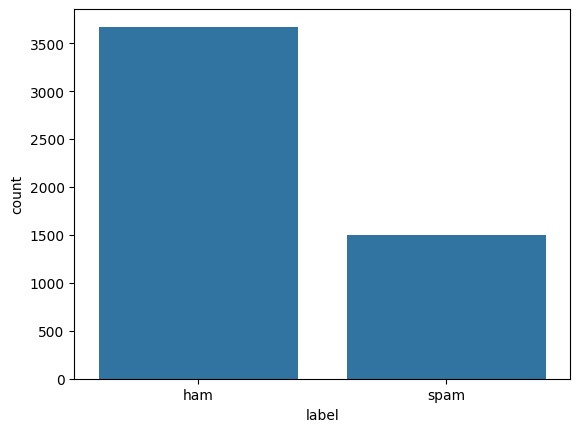

In [9]:
sns.countplot(x='label', data=data)
plt.show()

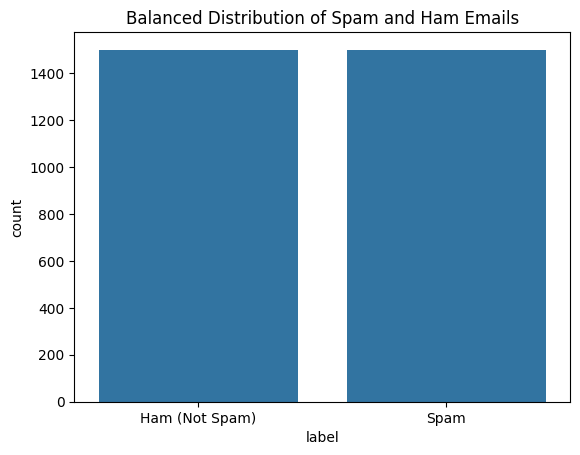

In [10]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

In [11]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [12]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [13]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


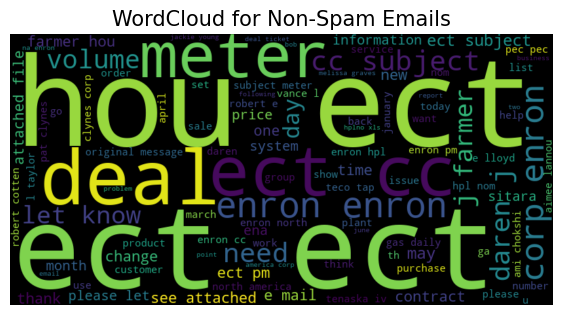

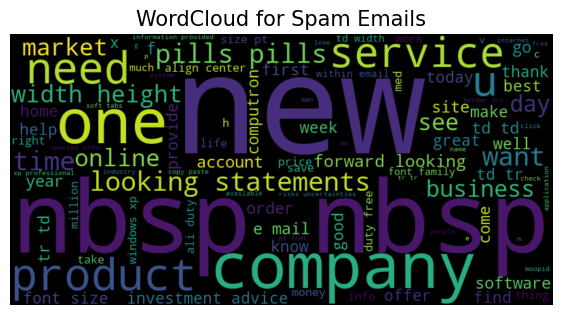

In [14]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [15]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [16]:
# Bidirectional LSTM Neural Network for Binary Text Classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [17]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20


75/75 [==============================] - 8s 53ms/step - loss: 0.4766 - accuracy: 0.7631 - precision: 0.7037 - recall: 0.9193 - val_loss: 0.0983 - val_accuracy: 0.9717 - val_precision: 0.9558 - val_recall: 0.9860 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 3s 44ms/step - loss: 0.0648 - accuracy: 0.9800 - precision: 0.9679 - recall: 0.9934 - val_loss: 0.0665 - val_accuracy: 0.9850 - val_precision: 0.9792 - val_recall: 0.9895 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 4s 53ms/step - loss: 0.0177 - accuracy: 0.9950 - precision: 0.9918 - recall: 0.9984 - val_loss: 0.0673 - val_accuracy: 0.9850 - val_precision: 0.9792 - val_recall: 0.9895 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 4s 60ms/step - loss: 0.0132 - accuracy: 0.9979 - precision: 0.9975 - recall: 0.9984 - val_loss: 0.0640 - val_accuracy: 0.9867 - val_precision: 0.9826 - val_recall: 0.9895 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 4s

19/19 [==============================] - 0s 12ms/step - loss: 0.0640 - accuracy: 0.9867 - precision: 0.9826 - recall: 0.9895
Test Loss     : 0.0639960765838623
Test Accuracy : 0.9866666793823242
Test Precision: 0.9825783967971802
Test Recall   : 0.9894737005233765
19/19 [==============================] - 0s 9ms/step


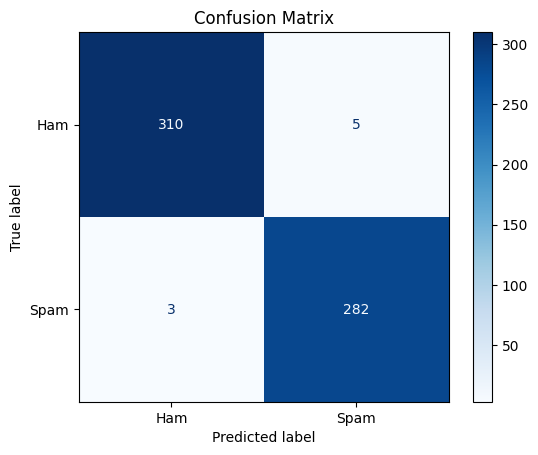


Confusion Matrix Breakdown:
True Negatives : 310
False Positives: 5
False Negatives: 3
True Positives : 282


In [24]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_sequences, test_Y)

print("Test Loss     :", test_loss)
print("Test Accuracy :", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall   :", test_recall)

# --- Confusion Matrix ---
# Predict class probabilities
y_probs = model.predict(test_sequences)

# Convert to class labels (threshold = 0.5)
y_pred = (y_probs > 0.5).astype(int).flatten()
y_true = test_Y.to_numpy().flatten()

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Optional: Print raw values
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives : {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives : {tp}")


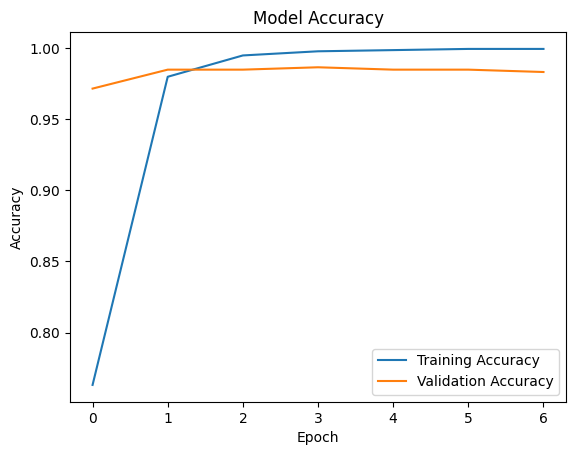

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [49]:
import email
from email import policy
from bs4 import BeautifulSoup
import os

def parse_eml_file(eml_path):
    with open(eml_path, 'r', encoding='utf-8', errors='ignore') as f:
        msg = email.message_from_file(f, policy=policy.default)

    # Extract subject
    subject = msg['Subject'] or ''

    # Extract body (prefer plain text, fall back to HTML)
    body = ''
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            if content_type == 'text/plain':
                body = part.get_content()
                break
            elif content_type == 'text/html' and not body:
                html = part.get_content()
                body = BeautifulSoup(html, 'html.parser').get_text()
    else:
        content_type = msg.get_content_type()
        if content_type == 'text/plain':
            body = msg.get_content()
        elif content_type == 'text/html':
            html = msg.get_content()
            body = BeautifulSoup(html, 'html.parser').get_text()

    full_text = f"{subject}\n{body}"
    return full_text

def parse_txt_file(txt_path):
    with open(txt_path, 'r', encoding='utf-8', errors='ignore') as f:
        return f.read()
    
def classify_email_file(file_path):
    ext = os.path.splitext(file_path)[-1].lower()
    if ext == ".eml":
        text = parse_eml_file(file_path)
    elif ext == ".txt":
        text = parse_txt_file(file_path)
    else:
        raise ValueError("Unsupported file format. Only .txt and .eml are supported.")

    # Tokenize & pad
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded)[0][0]
    label = "Spam" if prediction > 0.5 else "Ham"

    # Output
    print(f"\n--- File: {file_path} ---")
    print(f"Preview: {text[:300]}...\n")
    print(f"Prediction: {label} (Confidence: {prediction:.6f})")

def load_eml_dataset(base_path):
    true_labels = []
    predictions = []

    for label_folder in ['Ham', 'Spam']:
        label_value = 0 if label_folder.lower() == 'ham' else 1
        folder_path = os.path.join(base_path, label_folder)

        for filename in os.listdir(folder_path):
            if not filename.lower().endswith('.eml'):
                continue

            file_path = os.path.join(folder_path, filename)
            try:
                text = parse_eml_file(file_path)

                # Tokenize and pad
                seq = tokenizer.texts_to_sequences([text])
                padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

                # Predict
                prob = model.predict(padded)[0][0]
                pred = 1 if prob > 0.5 else 0

                true_labels.append(label_value)
                predictions.append(pred)
            except Exception as e:
                print(f"[ERROR] {filename}: {e}")
                continue

    return np.array(true_labels), np.array(predictions)

1/1 [==============================] - 0s 26ms/step


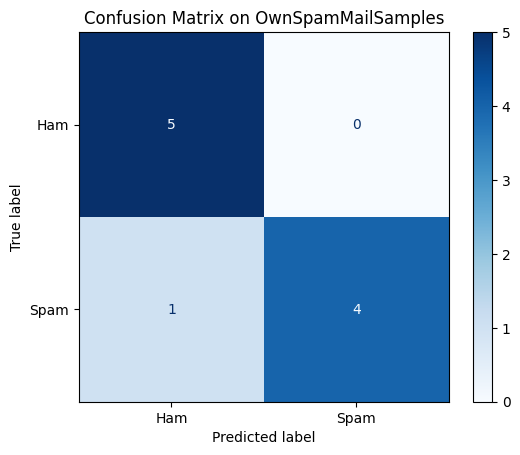

In [52]:
# === Run batch test ===
true_y, pred_y = load_eml_dataset("OwnSpamMailSamples")

# === Confusion Matrix ===
cm = confusion_matrix(true_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on OwnSpamMailSamples")
plt.show()

In [53]:
classify_email_file(r"OwnSpamMailSamples\Spam\Samsung Hot Picks for a Cool April.eml")

1/1 [==============================] - 0s 24ms/step

--- File: OwnSpamMailSamples\Spam\Samsung Hot Picks for a Cool April.eml ---
Preview: Samsung Hot Picks for a Cool April
You don't often get email from my_shop@samsung.com. Learn why this is important<https://aka.ms/LearnAboutSenderIdentification>
Don't miss this month's must have -- they're going fast.
View this email in your browser<https://mailchi.mp/samsung/samsung-hot-picks-for-...

Prediction: Ham (Confidence: 0.061994)
